In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

In [2]:
trainset = torchvision.datasets.FashionMNIST(
    root='../chap08/data',train=True,
    download=True,
    transform=transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../chap08/data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../chap08/data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../chap08/data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../chap08/data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../chap08/data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../chap08/data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../chap08/data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../chap08/data\FashionMNIST\raw



In [3]:
batch_size = 8
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [5]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([8, 1, 28, 28])
torch.Size([1, 28, 28])
9


In [6]:
def imshow(img,title):
    plt.figure(figsize=(batch_size*4,4))
    plt.axis('off')
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.title(title)
    plt.show()

In [10]:
def show_batch_images(dataloader):
    images,labels = next(iter(dataloader))

    img = torchvision.utils.make_grid(images)
    imshow(img,title=[str(x.item()) for x in labels])

    return images,labels

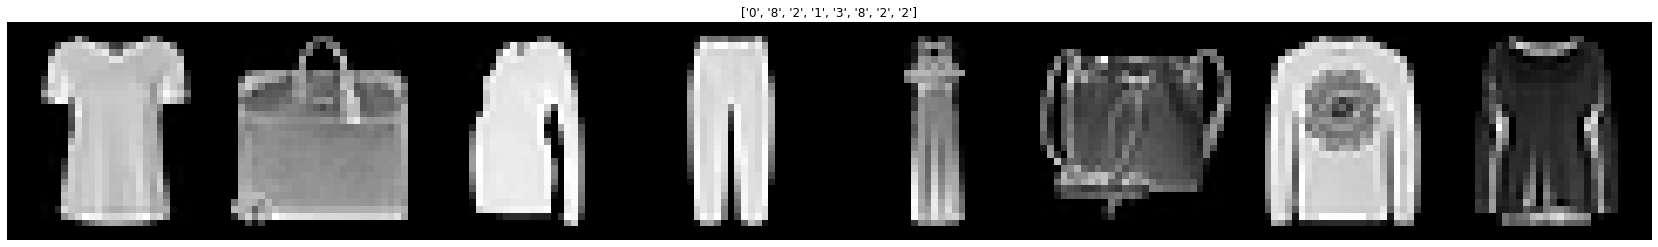

In [11]:
images, labels = show_batch_images(trainloader)

In [12]:
class NormalNet(nn.Module):
    def __init__(self):
        super(NormalNet,self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784,48),
            nn.ReLU(),
            nn.Linear(48,24),
            nn.ReLU(),
            nn.Linear(24,10)
        )
    def forward(self,x):
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [13]:
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet,self).__init__()
        self.classifier= nn.Sequential(
            nn.Linear(784,48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48,24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24,10)
        )
    def forward(self,x):
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x


In [27]:
model = NormalNet()
print(model)
for param in model.parameters():
    print(type(param),param.size())

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)
<class 'torch.nn.parameter.Parameter'> torch.Size([48, 784])
<class 'torch.nn.parameter.Parameter'> torch.Size([48])
<class 'torch.nn.parameter.Parameter'> torch.Size([24, 48])
<class 'torch.nn.parameter.Parameter'> torch.Size([24])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 24])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


In [28]:
model_bn = BNNet()
print(model_bn)
for param in model_bn.parameters():
    print(type(param),param.size())

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)
<class 'torch.nn.parameter.Parameter'> torch.Size([48, 784])
<class 'torch.nn.parameter.Parameter'> torch.Size([48])
<class 'torch.nn.parameter.Parameter'> torch.Size([48])
<class 'torch.nn.parameter.Parameter'> torch.Size([48])
<class 'torch.nn.parameter.Parameter'> torch.Size([24, 48])
<class 'torch.nn.parameter.Parameter'> torch.Size([24])
<class 'torch.nn.parameter.Parameter'> torch.Size([24])
<class 'torch.nn.parameter.Parameter'> torch.Size([24])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 24])
<class 'torch.nn.parameter.Parameter'> torch.Size([

In [29]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [30]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(),lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(),lr=0.01)

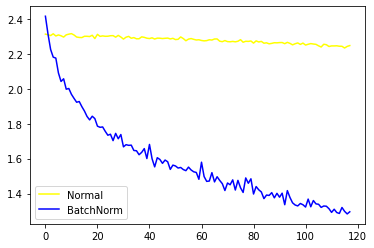

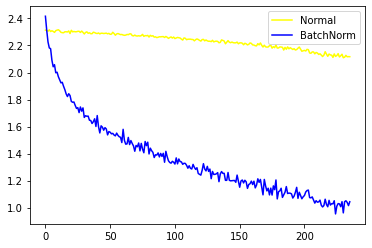

In [31]:
loss_arr = []
loss_bn_arr = []
max_epochs = 2

for epoch in range(max_epochs):
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        loss.backward()
        opt.step()

        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn,labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

    plt.plot(loss_arr,'yellow',label='Normal')
    plt.plot(loss_bn_arr,'blue',label='BatchNorm')
    plt.legend()
    plt.show()


In [32]:
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1,1,N),1)
y_train = x_train + noise*torch.normal(torch.zeros(N,1),torch.ones(N,1))

x_test = torch.unsqueeze(torch.linspace(-1,1,N),1)
y_test = x_test + noise*torch.normal(torch.zeros(N,1),torch.ones(N,1))

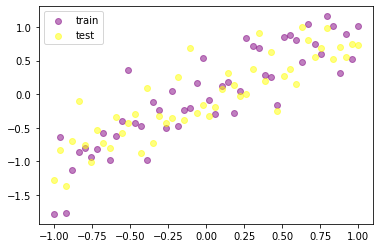

In [33]:
plt.scatter(x_train.data.numpy(),y_train.data.numpy(),c='purple',alpha=0.5,label='train')
plt.scatter(x_test.data.numpy(),y_test.data.numpy(),c='yellow',alpha=0.5,label='test')
plt.legend()
plt.show()

In [34]:
N_h = 100
model = torch.nn.Sequential(
    torch.nn.Linear(1,N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h,N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h,1)
)
model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1,N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h,N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h,1)
)

In [35]:
opt = torch.optim.Adam(model.parameters(),lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(),lr=0.01)
loss_fn = torch.nn.MSELoss()

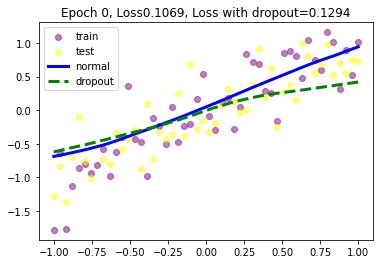

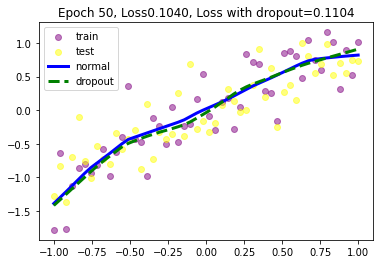

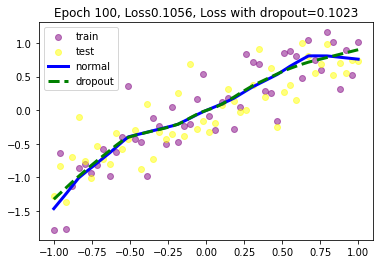

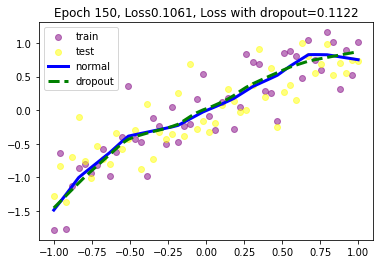

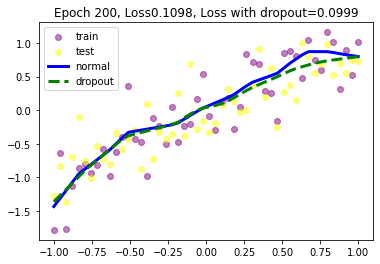

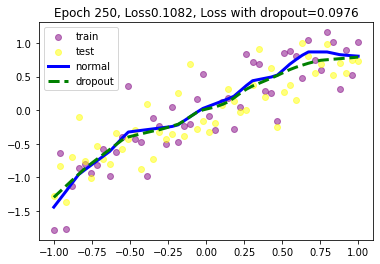

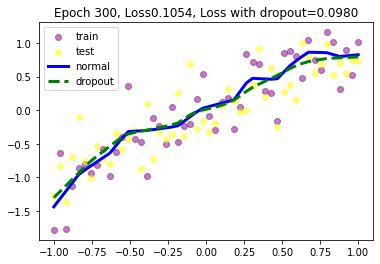

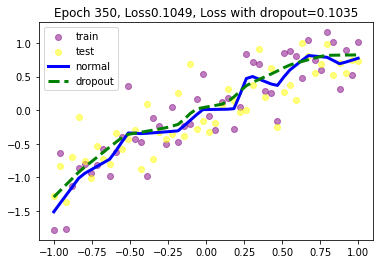

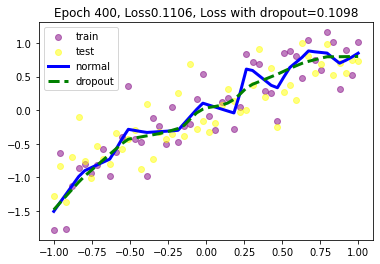

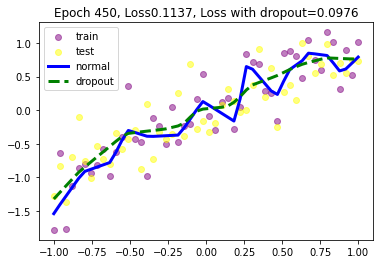

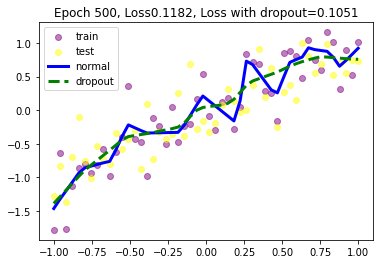

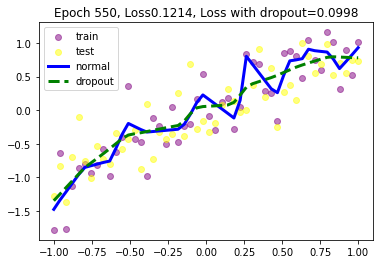

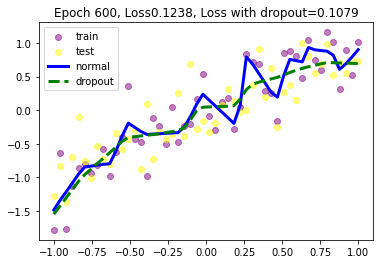

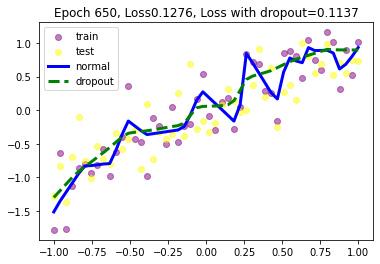

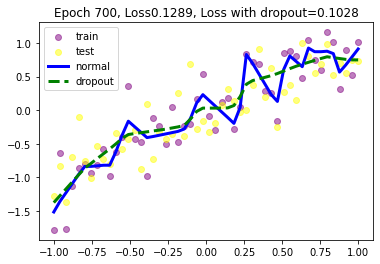

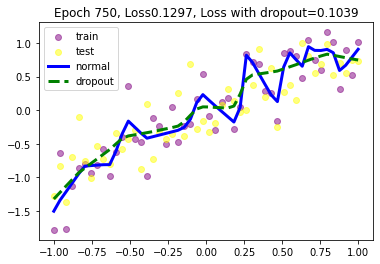

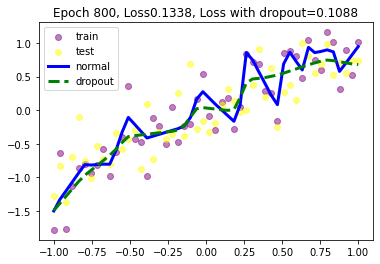

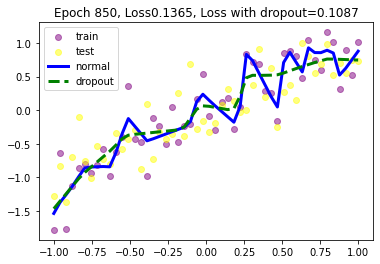

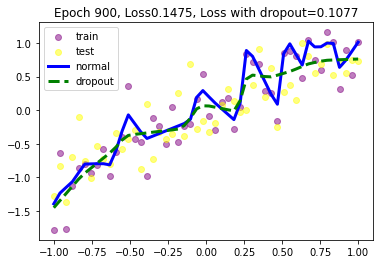

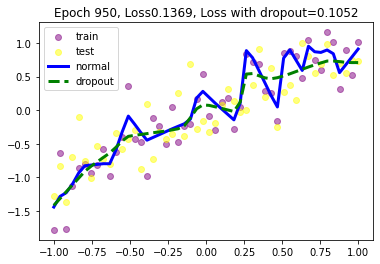

In [36]:
max_epochs = 1000
for epoch in range(max_epochs):
    pred = model(x_train)
    loss = loss_fn(pred,y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred_dropout=model_dropout(x_train)
    loss_dropout=loss_fn(pred_dropout,y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()

    if epoch % 50==0:
        model.eval()
        model_dropout.eval()

        test_pred = model(x_test)
        test_loss = loss_fn(test_pred,y_test)

        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout,y_test)

        plt.scatter(x_train.data.numpy(),y_train.data.numpy(),c='purple',alpha=0.5,label='train')
        plt.scatter(x_test.data.numpy(),y_test.data.numpy(),c='yellow',alpha=0.5,label='test')
        plt.plot(x_test.data.numpy(),test_pred.data.numpy(),'b-',lw=3,label='normal')
        plt.plot(x_test.data.numpy(),test_pred_dropout.data.numpy(),'g--',lw=3,label='dropout')
        plt.title('Epoch %d, Loss%0.4f, Loss with dropout=%0.4f'%(epoch,test_loss,test_loss_dropout))
        plt.legend()
        model.train()
        model_dropout.train()
        plt.pause(0.05)

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms,datasets

import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
from tqdm import tqdm
matplotlib.style.use('ggplot')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

In [43]:
train_dataset = datasets.ImageFolder(
    root=r'./dl_pytorch/chap08/data/archive/train',
    transform=train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,batch_size=32,shuffle=True
)
val_dataset = datasets.ImageFolder(
    root=r'./dl_pytorch/chap08/data/archive/test',
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,batch_size=32,shuffle=False
)


In [44]:
def resnet50(pretrained=True,requires_grad = False):
    model = models.resnet50(progress=True,pretrained=pretrained)
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad=False
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad=True
    model.fc = nn.Linear(2048,2)
    return model

In [45]:
class LRScheduler():
    def __init__(self,optimizer,patience=5,min_lr=1e-6,factor=0.5):
        self.optimizer=optimizer
        self.patience=patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.patience,
            factor = self.factor,
            min_lr=self.min_lr,
            verbose=True
        )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [46]:
class EarlyStopping():
    def __init__(self,patience=5,verbose=False,delta=0,path='./dl_pytorch/chap08/data/checkpoint.pt'):
        self.patience=patience
        self.verbose=verbose
        self.counter=0
        self.best_score=None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path=path

    def __call__(self, val_loss,model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss,model)
        elif score < self.best_score + self.delta:
            self.counter+=1
            print(f'EarlyStopping counter:{self.counter} out of {self.patience}')
            if self.counter>=self.patience:
                self.early_stop = True
        else:
            self.best_score=score
            self.save_checkpoint(val_loss,model)
            self.counter=0

In [54]:
parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler',dest='lr_scheduler',action='store_true')
parser.add_argument('--early-stopping',dest='early_stopping',action='store_true')
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
args = vars(parser.parse_args())

In [55]:
print(f'Computation device:{device}\n')
model = models.resnet50(pretrained=True).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,}total parameters")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Computation device:cuda:0



C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


25,557,032total parameters
25,557,032 training parameters.


In [50]:
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

In [51]:
loss_plot_name = 'loss'
acc_plot_name = 'accuracy'
model_name = 'model'

In [56]:
if args['lr_scheduler']:
    print('INFO : Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    loss_plot_name = 'lrs_loss'
    acc_plot_name = 'lrs_accuracy'
    model_name = 'lrs_model'
if args['early_stopping']:
    print('INFO : Initializing early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss'
    acc_plot_name = 'es_accuracy'
    model_name = 'es_model'

In [60]:
def training(model,train_dataloader,train_dataset,optimizer,criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader),total = int(len(train_dataset)/train_dataloader.batch_size))
    for i,data in prog_bar:
        counter+=1
        data,target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs,target)
        train_running_loss +=loss.item()
        _,preds = torch.max(outputs.data,1)
        train_running_correct += (preds==target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [61]:
def validate(model,test_dataloader,val_dataset,criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader),total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i,data in prog_bar:
            counter+=1
            data, target = data[0].to(device),data[1].to(device)
            total +=target.size(0)
            outputs = model(data)
            loss = criterion(outputs,target)

            val_running_loss +=loss.item()
            _,preds = torch.max(outputs.data,1)
            val_running_correct +=(preds == target).sum().item()

        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct/total
        return val_loss, val_accuracy

In [63]:
train_loss, train_accuracy = [],[]
val_loss , val_accuracy = [],[]

start = time.time()
for epoch in range(epochs):
    print(f'Epoch{epoch+1} of {epochs}')
    train_epoch_loss,train_epoch_accuracy = training(
        model,train_dataloader,train_dataset,optimizer,criterion
    )
    val_epoch_loss,val_epoch_accuracy = validate(
        model,val_dataloader,val_dataset,criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if args['lr_scheduler']:
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']:
        early_stopping(val_epoch_loss,model)
        if early_stopping.early_stop:
            break
    print(f'Training Loss:{train_epoch_loss:.4f}, Train Acc:{train_epoch_accuracy:.2f}')
    print(f'Val Loss:{val_epoch_loss:.4f}, Val Acc:{val_epoch_accuracy:.2f}')
end = time.time()
print(f'Training time:{(end-start)/60:.3f}minutes')

Epoch1 of 100
Training


16it [00:04,  3.22it/s]                        


Validating


16it [00:03,  5.08it/s]                        


Training Loss:9.0392, Train Acc:0.00
Val Loss:9.5995, Val Acc:0.00
Epoch2 of 100
Training


 73%|███████▎  | 11/15 [00:03<00:01,  3.24it/s]


KeyboardInterrupt: 